In [47]:
import os
import numpy as np
import pandas as pd
import napari
import matplotlib.pyplot as plt
from matplotlib.path import Path
from scipy.spatial import ConvexHull


In [49]:
# ======== 1. LOAD DATA ========
transcripts_path = r"C:\Users\yasee\OneDrive\Desktop\20251125_MT_48hrs_MH2_Sag18_ID58144\transcripts.tsv"

try:
    transcripts_df = pd.read_csv(
        transcripts_path,
        sep="\t",
        skiprows=1,
        header=None,
        names=["x", "y", "gene", "count"],
        dtype={
            "x": "float32",
            "y": "float32",
            "gene": "category",
            "count": "int16",
        },
        on_bad_lines='warn'  # Handle potential formatting issues
    )
except FileNotFoundError:
    print(f"Error: File not found at {transcripts_path}")
    exit()

print(f"Total transcripts: {len(transcripts_df):,}")
print(transcripts_df.dtypes)

Total transcripts: 580,983,326
x         float32
y         float32
gene     category
count       int16
dtype: object


In [50]:
# ======== 2. VISUALIZATION SAMPLE ========
sample_frac = 0.05  # Consider 1% for very large datasets
viz_df = transcripts_df.sample(frac=sample_frac, random_state=42)

viewer = napari.Viewer()
viewer.add_points(
    viz_df[["x", "y"]].values,
    name="Transcripts (sample)",
    size=2,
    face_color="red",
    opacity=0.3
)

print("Draw a polygon ROI using the Shapes tool.")
print("Export it as CSV when done.")

napari.run()

Draw a polygon ROI using the Shapes tool.
Export it as CSV when done.


In [53]:
# ======== 3. LOAD POLYGON ========
polygon_path = r"C:\Users\yasee\Downloads\20251125_MT_48hrs_MH2_Sag18_ID58144croppedhippo.csv"

try:
    shapes_df = pd.read_csv(polygon_path)
    if {"axis-0", "axis-1"}.issubset(shapes_df.columns):
        polygon = shapes_df[["axis-0", "axis-1"]].values
    elif {"x", "y"}.issubset(shapes_df.columns):
        polygon = shapes_df[["x", "y"]].values
    else:
        print("Error: Polygon CSV must contain 'axis-0', 'axis-1' or 'x', 'y' columns")
        exit()
        
    polygon = np.vstack([polygon, polygon[0]])  # close loop
    print(f"Polygon loaded with {len(polygon)} vertices")
    
except FileNotFoundError:
    print(f"Error: Polygon file not found at {polygon_path}")
    exit()

Polygon loaded with 90 vertices


In [55]:
# ======== 4. CROP TRANSCRIPTS ========
path = Path(polygon)

# For large datasets, consider processing in chunks
mask = path.contains_points(transcripts_df[["x", "y"]].values)
cropped_transcripts = transcripts_df[mask].copy()
print(f"Cropped transcripts: {len(cropped_transcripts):,} / {len(transcripts_df):,}")

Cropped transcripts: 11,896,549 / 580,983,326


In [56]:
# ======== 5. CALCULATE ACCURATE AREA ========
def polygon_area(x, y):
    """Shoelace formula for polygon area"""
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

# Use the original polygon (before closing)
if polygon.shape[0] > 2:  # Ensure it's a valid polygon
    area = polygon_area(polygon[:-1, 0], polygon[:-1, 1])
    print(f"\nROI area (polygon): {area:,.2f} units²")
else:
    print("Warning: Invalid polygon for area calculation")



ROI area (polygon): 1,616,575.33 units²


In [57]:
# ======== 6. ANALYSIS ========
print("=== BASIC STATS ===")
print(f"Total transcripts: {len(cropped_transcripts):,}")
print(f"Unique genes: {cropped_transcripts['gene'].nunique():,}")

=== BASIC STATS ===
Total transcripts: 11,896,549
Unique genes: 5,006


In [58]:
# Transcript density (if area is valid)
if 'area' in locals() and area > 0:
    density = len(cropped_transcripts) / area
    print(f"Transcript density: {density:.2f} transcripts/unit²")

Transcript density: 7.36 transcripts/unit²


In [59]:
# Top genes
top_genes = (
    cropped_transcripts
    .groupby("gene")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(20)
)
print("\nTop 20 genes:")
for g, c in top_genes.items():
    print(f"  {g}: {c:,}")



Top 20 genes:
  Camk2a: 413,538
  Aldoa: 116,479
  Camk2b: 110,872
  Gfap: 108,006
  Map2: 102,182
  Ndrg2: 85,372
  Aldoc: 79,429
  Snap25: 76,821
  Ckb: 71,769
  Gria1: 65,979
  Atp1b2: 64,932
  Cyfip2: 59,633
  Map1b: 57,572
  Slc1a3: 57,067
  Kcnab2: 56,743
  Ywhag: 54,338
  Dnm1: 53,259
  Adcy1: 52,973
  Ptk2b: 51,711
  Gnao1: 51,340


C:\Users\yasee\AppData\Local\Temp\ipykernel_20592\2295440097.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("gene")["count"]


In [60]:
# ======== 7. SAVE RESULTS ========
output_dir = r"C:\Users\yasee\OneDrive\Documents"
os.makedirs(output_dir, exist_ok=True)

# Save cropped transcripts
output_path = os.path.join(output_dir, "20251125_MT_48hrs_MH2_Sag18_ID58144croppedhippo.tsv")
cropped_transcripts.to_csv(output_path, sep="\t", index=False)

# Save polygon
polygon_df = pd.DataFrame(polygon, columns=["x", "y"])
polygon_path_out = os.path.join(output_dir, "20251125_MT_48hrs_MH2_Sag18_ID58144croppedpolygon.tsv")
polygon_df.to_csv(polygon_path_out, sep="\t", index=False)

print(f"\nSaved outputs to: {output_dir}")
print(f"  - Cropped transcripts: {output_path}")
print(f"  - Polygon coordinates: {polygon_path_out}")


Saved outputs to: C:\Users\yasee\OneDrive\Documents
  - Cropped transcripts: C:\Users\yasee\OneDrive\Documents\20251125_MT_48hrs_MH2_Sag18_ID58144croppedhippo.tsv
  - Polygon coordinates: C:\Users\yasee\OneDrive\Documents\20251125_MT_48hrs_MH2_Sag18_ID58144croppedpolygon.tsv


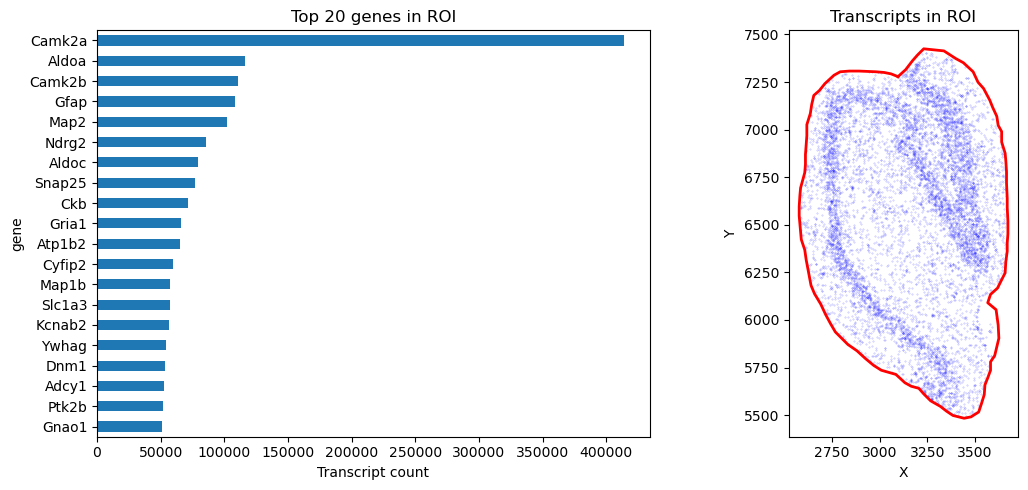

In [61]:
# ======== 8. VISUALIZATION ========
if len(top_genes) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Top genes
    top_genes.plot(kind="barh", ax=axes[0])
    axes[0].invert_yaxis()
    axes[0].set_xlabel("Transcript count")
    axes[0].set_title("Top 20 genes in ROI")
    
    # Plot 2: Spatial distribution (sample)
    sample_cropped = cropped_transcripts.sample(n=min(10000, len(cropped_transcripts)), random_state=42)
    axes[1].scatter(sample_cropped["x"], sample_cropped["y"], s=0.1, alpha=0.3, c='blue')
    axes[1].plot(polygon[:, 0], polygon[:, 1], 'r-', linewidth=2)
    axes[1].set_aspect('equal')
    axes[1].set_title("Transcripts in ROI")
    axes[1].set_xlabel("X")
    axes[1].set_ylabel("Y")
    
    plt.tight_layout()
    plt.show()